In [1]:
import os

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.ticker import MaxNLocator
# import sys
# sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '../..')))
# import utils.mpl_pubstyle  # noqa: F401
# Set to LateX
import matplotlib as mpl
mpl.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern"],
    "text.latex.preamble": r"\usepackage{amsmath}\usepackage{amsfonts}\usepackage{amssymb}"
})

In [2]:
# NvsNt1 --> Nh=100 (tested too many Nts and Ns, see comment in next cell)
# NvsNt2 --> Nh=200
# NvsNt3 --> Nh=50
# NvsNt4 --> Nh=150

Nh = 100
problem_name = 'AdvDiff2D'
base_dir = os.path.abspath(os.path.join(os.getcwd(), ''))
path = os.path.join(base_dir, os.pardir, os.pardir, '__RESULTS', problem_name, 'NvsNt2')
# path = "/home/riccardo/Desktop/PhD/MyRepos/FD-PyIMEX-RB/__RESULTS/AdvDiff2D/NvsNt1"
results = np.load(os.path.join(path, "results.npz"), allow_pickle=True)

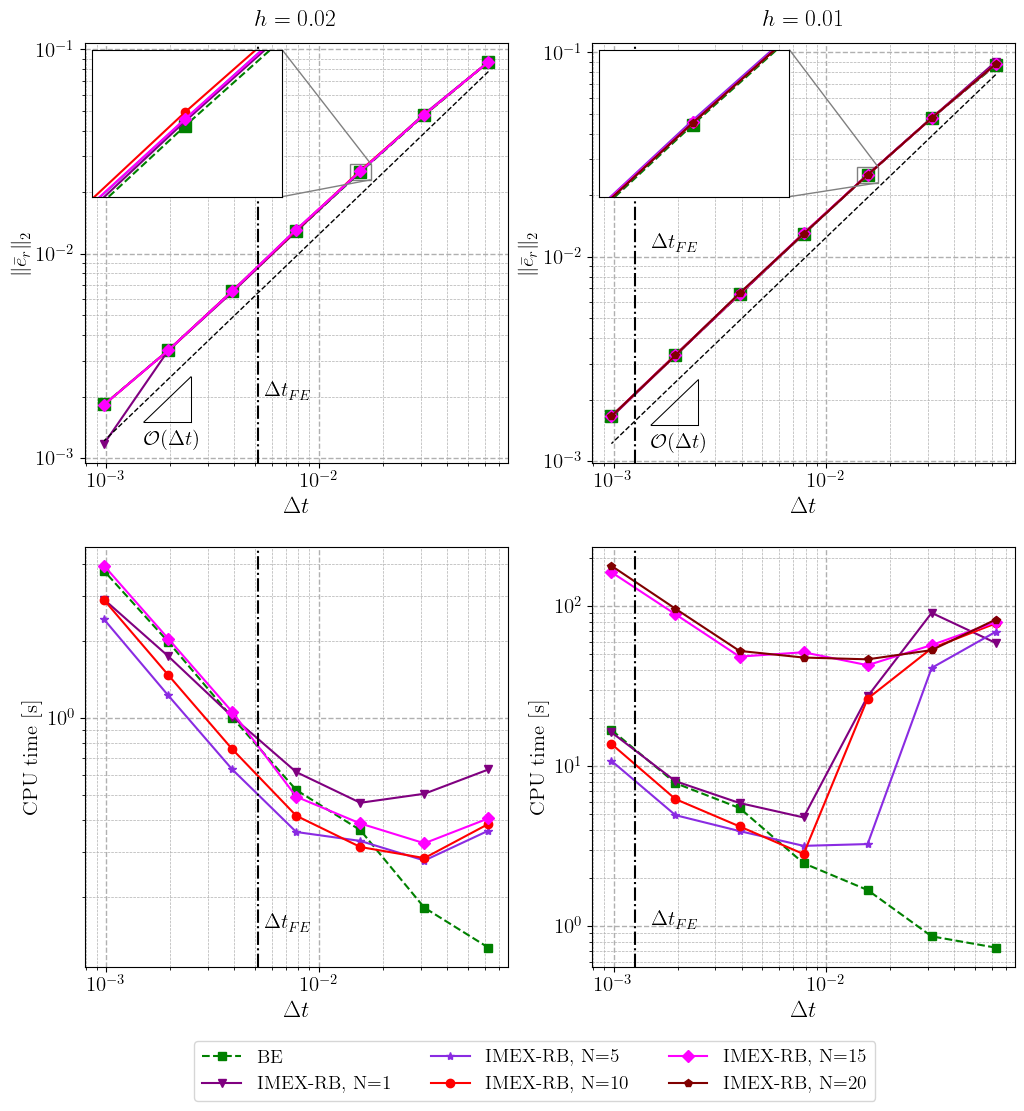

In [ ]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset

base_dir = os.path.abspath(os.path.join(os.getcwd(), ''))
problem_name = 'AdvDiff2D'
subdirs = [('NvsNt1', 100), ('NvsNt2', 200)]
markers = ['s', 'v', '*', 'o', 'D', 'p']
colors = ['green', 'purple', 'blueviolet', 'red', 'magenta', 'maroon']
xdeltaFE = [5.5e-3, 5.5e-3, 1.5e-3, 1.5e-3]
ydeltaFE = [2e-3, 1.5e-1, 1.1e-2, 1e0]
fig, axs = plt.subplots(2, 2, figsize=(12, 12))

for col, (subdir, Nh) in enumerate(subdirs):
    pos = axs[0, col].get_position()
    x = pos.x0 + pos.width / 2
    y = pos.y1 + 0.01
    fig.text(
        x, y,
        rf"$h = {2/Nh:.2f}$",  # The domain has length 2
        ha="center", va="bottom", fontsize=17
    )
    path = os.path.join(base_dir, os.pardir, os.pardir,
                        '__RESULTS', problem_name, subdir)
    results = np.load(os.path.join(path, "results.npz"), allow_pickle=True)
    Nt_FE = results['Nt_FE'][None][0][0]
    errIMEX_raw = results['errors_l2'][None][0]['IMEX-RB']
    errBE_raw = results['errors_l2'][None][0]['BE']
    timesIMEX_raw = results['times'][None][0]['IMEX-RB']
    timesBE_raw = results['times'][None][0]['BE']
    subiters_raw = results['subiters'][None][0]['IMEX-RB']

    is_test1 = subdir.endswith('1')
    if is_test1:
        Ns = results['N_values'][None][0][:-1]  # --> comment the last slice for tests different than the first
        Nts = results['Nt_values'][None][0][2:-1]
        errIMEX = errIMEX_raw[2:-1, :-1]
        errBE = errBE_raw[2:-1]
        timesIMEX = timesIMEX_raw[2:-1, :-1]
        timesBE = timesBE_raw[2:-1]
        subiters = subiters_raw[2:-1, :-1]
    else:
        Ns = results['N_values'][None][0]# [:-1]  # --> comment the last slice for tests different than the first
        Nts = results['Nt_values'][None][0]#[2:-1]
        errIMEX = errIMEX_raw
        errBE = errBE_raw
        timesIMEX = timesIMEX_raw
        timesBE = timesBE_raw
        subiters = subiters_raw

    mask = np.zeros_like(subiters, dtype=bool)
    for i, _Nt in enumerate(Nts):
        mask[i, :, :_Nt] = True
    masked_subiters = np.ma.masked_array(subiters, mask=~mask)

    # Top subplot: relative error with inset
    ax_err = axs[0, col]
    ax_err.loglog(1 / Nts, errBE, f'--{markers[0]}',
                  markersize=8, color=colors[0], label='BE')
    for i in range(errIMEX.shape[1]):
        ax_err.loglog(
            1 / Nts,
            errIMEX[:, i],
            f'-{markers[i+1]}',
            markersize=6,
            color=colors[i+1],
            label=f'IMEX-RB, N={Ns[i]}'
        )
    ax_err.loglog(
        1 / Nts,
        (Nts[0] * errBE[0] * 0.9) / Nts,
        color='k',
        linestyle='--',
        linewidth=1
    )
    x0, y0 = 0.0015, 0.0015
    dx = 0.001
    dy = dx
    ax_err.plot([x0, x0 + dx], [y0, y0], 'k-', linewidth=0.75)
    ax_err.plot([x0 + dx, x0 + dx], [y0, y0 + dy], 'k-', linewidth=0.75)
    ax_err.plot([x0 + dx, x0], [y0 + dy, y0], 'k-', linewidth=0.75)
    ax_err.text(x0, y0 - dy / 2.5, r"$\mathcal{O}(\Delta t)$",
                fontsize=15, ha='left', va='bottom')
    ax_err.axvline(1 / Nt_FE, color='k', linestyle='-.')
    ax_err.text(xdeltaFE[2*col], ydeltaFE[2*col], r"$\Delta t_{FE}$",
                fontsize=15, color='k')

    axins = inset_axes(ax_err, width="45%", height="35%", loc='upper left')
    axins.loglog(1 / Nts, errBE, f'--{markers[0]}',
                 markersize=8, color=colors[0])
    for i in range(errIMEX.shape[1]):
        axins.loglog(
            1 / Nts,
            errIMEX[:, i],
            f'-{markers[i+1]}',
            markersize=6,
            color=colors[i+1]
        )
    axins.set_xlim(1.4e-2, 1.75e-2)
    axins.set_ylim(2.3e-2, 2.75e-2)
    axins.tick_params(axis='both', which='both',
                      bottom=False, top=False,
                      left=False, right=False,
                      labelbottom=False, labelleft=False)
    mark_inset(ax_err, axins, loc1=1, loc2=4, fc="none", ec="0.5")

    ax_err.grid(which="major", linewidth=1, linestyle='--')
    ax_err.grid(which="minor", linewidth=0.5, linestyle='--')
    ax_err.tick_params(axis='both', which='major', labelsize=15)
    ax_err.set_xlabel(r"$\Delta t$", fontsize=17)
    ax_err.set_ylabel(r"$\|\bar{e}_r\|_2$", fontsize=15)

    # Bottom subplot: CPU time
    ax_time = axs[1, col]
    ax_time.loglog(1 / Nts, timesBE, f'--{markers[0]}',
                   markersize=6, color=colors[0], label='BE')
    for i in range(timesIMEX.shape[1]):
        ax_time.loglog(
            1 / Nts,
            timesIMEX[:, i],
            f'-{markers[i+1]}',
            markersize=6,
            color=colors[i+1],
            label=f'IMEX-RB, N={Ns[i]}'
        )
    ax_time.axvline(1 / Nt_FE, color='k', linestyle='-.')
    ax_time.text(xdeltaFE[2*col+1], ydeltaFE[2*col+1], r"$\Delta t_{FE}$",
                 fontsize=15, color='k')
    ax_time.grid(which="major", linestyle='--', linewidth=1)
    ax_time.grid(which="minor", linestyle='--', linewidth=0.5)
    ax_time.tick_params(axis='both', which='major', labelsize=15)
    ax_time.set_xlabel(r"$\Delta t$", fontsize=17)
    ax_time.set_ylabel("CPU time [s]", fontsize=15)
    # ax_time.set_ylim([None, 6e0])

# External legend below all subplots
handles, labels = axs[1,1].get_legend_handles_labels()
fig.legend(
    handles, labels,
    loc='lower center',
    bbox_to_anchor=(0.5, -0.01),
    ncol=3,
    fontsize=14
)

#plt.tight_layout(rect=[0, 0.03, 1, 1])
plt.savefig(f'plots/combined_NvsNt_Nh_100_200.pdf', bbox_inches="tight")



In [12]:
# NvsNt1 --> Nh=100 (tested too many Nts and Ns, see comment in next cell)
# NvsNt2 --> Nh=200
# NvsNt3 --> Nh=50
# NvsNt4 --> Nh=150

Nh = 100
problem_name = 'AdvDiff2D'
base_dir = os.path.abspath(os.path.join(os.getcwd(), ''))
path = os.path.join(base_dir, os.pardir, os.pardir, '__RESULTS', problem_name, 'NvsNt1')
# path = "/home/riccardo/Desktop/PhD/MyRepos/FD-PyIMEX-RB/__RESULTS/AdvDiff2D/NvsNt1"
results = np.load(os.path.join(path, "results.npz"), allow_pickle=True)

In [13]:

Nt_FE = results['Nt_FE'][None][0][0]

Ns = results['N_values'][None][0][:-1]  # --> comment the last slice for tests different than the first
Nts = results['Nt_values'][None][0][2:-1]

errIMEX = results['errors_l2'][None][0]['IMEX-RB'][2:-1, :-1]
errBE = results['errors_l2'][None][0]['BE'][2:-1]

timesIMEX = results['times'][None][0]['IMEX-RB'][2:-1, :-1]
timesBE = results['times'][None][0]['BE'][2:-1]

subiters = results['subiters'][None][0]['IMEX-RB'][2:-1, :-1]
mask = np.zeros_like(subiters, dtype=bool)
for i, _Nt in enumerate(Nts):
    mask[i, :, :_Nt] = True
masked_subiters = np.ma.masked_array(subiters, mask=~mask)

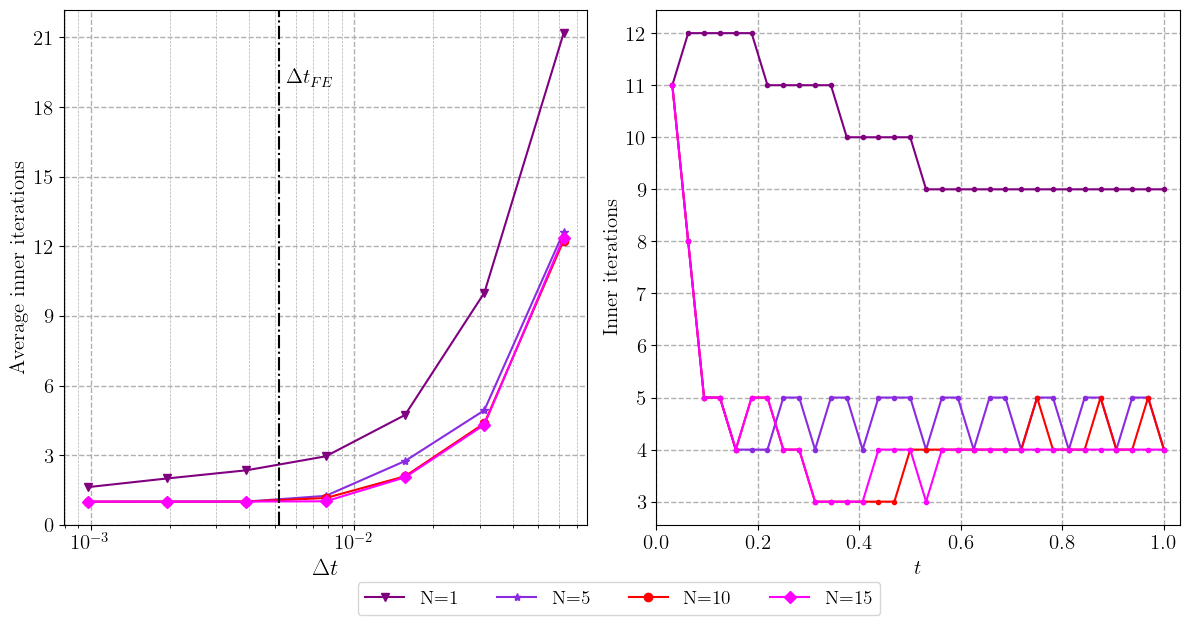

In [14]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

markers = ['v', '*', 'o', 'D']
colors = ['purple', 'blueviolet', 'red', 'magenta']

# Left subplot: average inner iterations
ax = axs[0]
for i, (m, c) in enumerate(zip(markers, colors)):
    mean_iter = np.mean(masked_subiters[:, i] + 1, axis=-1)
    ax.semilogx(
        1 / Nts,
        mean_iter,
        f'-{m}',
        markersize=6,
        color=c,
        label=f"N={Ns[i]}"
    )
ax.axvline(1 / Nt_FE, color='k', linestyle='-.')
ax.text(5.5e-3, 19, r"$\Delta t_{FE}$", fontsize=15, color='k')
ax.grid(which='major', linestyle='--', linewidth=1)
ax.grid(axis='x', which='minor', linestyle='--', linewidth=0.5)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.yaxis.set_major_locator(MaxNLocator(integer=True))
ax.set_xlabel(r"$\Delta t$", fontsize=17)
ax.set_ylabel("Average inner iterations", fontsize=15)

# Right subplot: inner iterations vs time
ax = axs[1]
Nt_idx = 1
tvec = np.linspace(0, 1, Nts[Nt_idx] + 1)[1:]
for i, c in enumerate(colors):
    ax.plot(
        tvec,
        subiters[Nt_idx, i, :Nts[Nt_idx]] + 1,
        '-o',
        markersize=3,
        color=c,
        label=f"N={Ns[i]}"
    )
ax.grid(which='major', linestyle='--', linewidth=1)
ax.set_xlim([0, 1 + 1 / Nts[Nt_idx]])
ax.yaxis.set_major_locator(MaxNLocator(integer=True))
ax.tick_params(axis='both', which='major', labelsize=15)
ax.set_xlabel(r"$t$", fontsize=15)
ax.set_ylabel("Inner iterations", fontsize=15)

# external legend on the right, one column
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(
    handles,
    labels,
    loc='lower center',
    bbox_to_anchor=(0.52, -0.05),
    fontsize=14,
    ncol=4
)
plt.tight_layout()
plt.savefig(f'plots/subiters_combined_N_Nh_{Nh}.pdf', bbox_inches="tight")
